# PHYS 512 - Problem Set 6

**André Vallières (260742187)**

## Problem 1

In [1]:
import ctypes
import matplotlib.pyplot as plt
import numba as nb
import numpy as np

In [2]:
# Get random numbers as array of tuples
rand_numbers = [tuple(map(int, x.split(' '))) for x in open("rand_points.txt").read().strip().split('\n')]

xs = np.array([r[0] for r in rand_numbers])
ys = np.array([r[1] for r in rand_numbers])
zs = np.array([r[2] for r in rand_numbers])

As suggested in the problem, we can plot $ax + by$ vs $z$ and see if there is anything strange.

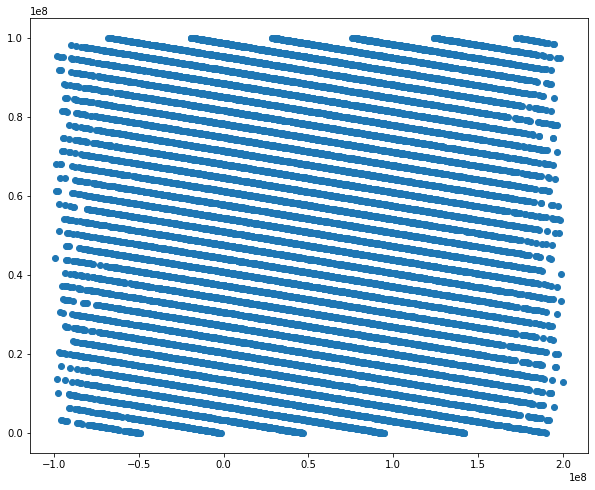

In [12]:
# Plot 2x - y VS z
plt.figure(figsize=(10,8))
plt.scatter(2 * xs - ys, zs)
plt.show()

Hence we see that plotting $2x - y$ vs $z$ gives a well-definite structure with ~35 planes; far from being random! Let's try the same thing with Python PRNG.

In [13]:
def get_rands(n):
    vals = np.empty(n)
    
    for i in range(n):
        vals[i] = np.random.rand()
        
    return vals

n = 300000000
vec = get_rands(n * 3)

vv = np.reshape(vec, [n, 3])
vmax = np.max(vv, axis=1)

maxval = 0.05 # About 5%
vv2 = vv[vmax < maxval, :]

xs = vv2[:,0]
ys = vv2[:,1]
zs = vv2[:,2]

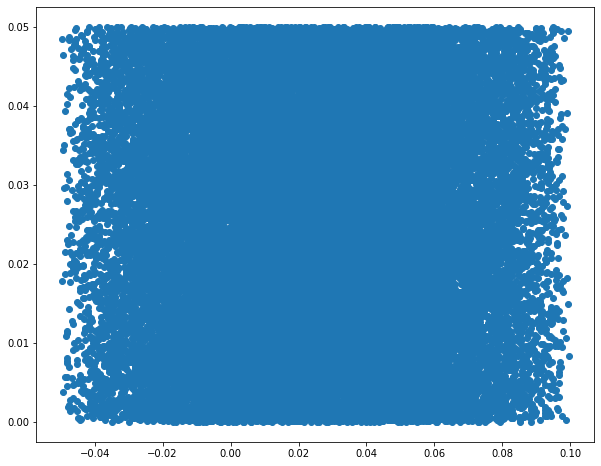

In [14]:
# Plot 2x - y VS z
plt.figure(figsize=(10,8))
plt.scatter(2 * xs - ys, zs)
plt.show()

Nothing that looks like the PRNG from the C library! Let's finally test the C PRNG on local computer.

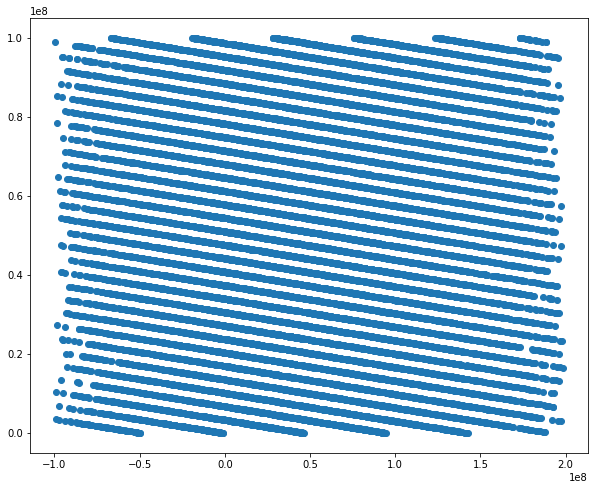

In [15]:
# Copied from test_broken_libc.py
mylib=ctypes.cdll.LoadLibrary("libc.dylib")
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int


@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec


n=300000000
vec=get_rands(n*3)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

xs = vv2[:,0]
ys = vv2[:,1]
zs = vv2[:,2]

# Plot 2x - y VS z
plt.figure(figsize=(10,8))
plt.scatter(2 * xs - ys, zs)
plt.show()

We see the same structure that shows non-randomness!

## Problem 2

Using the rejection method, if we want to sample from distribution $X$ with density $f$ using samples from distribution $Y$ with density $g$, we need $g > f$, always. We could add another parameter, $M$, so that $0 \leq f(Y)/Mg(Y) \leq 1$. The rejection criterion would then be $r > f(Y)/Mg(Y)$ for $r$ being sampled for a uniform distribution $U(0, 1)$.

### Lorentzian
\begin{equation}
g(x) = \frac{1}{\pi} \frac{1}{1 + x^2}
\end{equation}

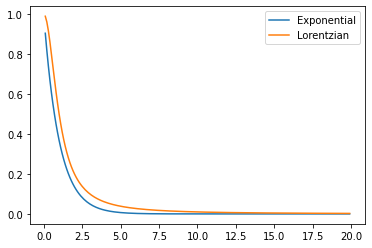

Can use Lorentzian with M = 3.141593: True


In [73]:
# Exponential vs Lorentzian
N = 20
x = np.arange(0.1, N, 0.1)

y_exp = np.exp(-x)
M = np.pi
y_lor = M/(np.pi * (1 + x**2))

# Compare visually
plt.plot(x, y_exp)
plt.plot(x, y_lor)
plt.legend(["Exponential", "Lorentzian"])
plt.show()

# Make sure always greater
print("Can use Lorentzian with M = %f:" % M, np.all(y_lor >= y_exp))

We need $M \geq \pi$ so the Lorentzian is always above the exponential. **Can use if** $M \geq \pi$.

### Gaussian
\begin{equation}
g(x) = \frac{1}{\sqrt{2 \pi} \sigma} e^{\frac{-x^2}{2\sigma^2}}
\end{equation}

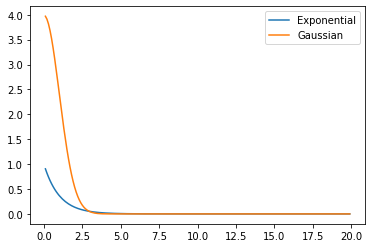

Can use Gaussian: False


In [79]:
# Exponential vs Gaussian
M = 10
std = 1

y_gauss = M * np.exp(-(x/std)**2/2) / (std * np.sqrt(2 * np.pi))

# Compare visually
plt.plot(x, y_exp)
plt.plot(x, y_gauss)
plt.legend(["Exponential", "Gaussian"])
plt.show()

# Make sure always greater
print("Can use Gaussian:", np.all(y_gauss >= y_exp))

There is just no way to have the Gaussian be above the exponential over the range $(0, \infty)$. **Cannot be used** (verified with Mathematica).

### Power
\begin{equation}
g(x) = \frac{\alpha - 1}{x_{\text{min}}} \Big( \frac{x}{x_{\text{min}}} \Big)^{-\alpha}, x > x_{\text{min}}
\end{equation}

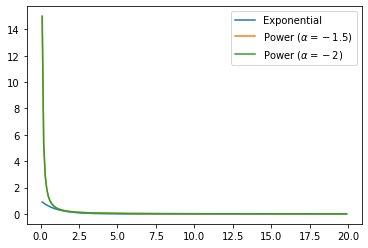

Can use Power with alpha = 1.5: True
Can use Power with alpha = 2: True


In [87]:
# Exponential vs Power
xmin = x[0]
M = 3

y_pow_1 = M * (0.5/xmin) * (x/xmin)**(-1.5)
y_pow_2 = M * (1/xmin) * (x/xmin)**(-2)

# Compare visually
plt.plot(x, y_exp)
plt.plot(x, y_pow_1)
plt.plot(x, y_pow_1)
plt.legend(["Exponential", r"Power ($\alpha = -1.5$)", r"Power ($\alpha = -2$)"])
plt.show()

# Make sure always greater
print("Can use Power with alpha = 1.5:", np.all(y_pow_1 >= y_exp))
print("Can use Power with alpha = 2:", np.all(y_pow_1 >= y_exp))

I could not find a closed expression for minimum value of $M$, but it seems we can do an exponential sampling for a high enough value of $M$.

### Generating exponential deviates

In [134]:
# From Lorentzian
r = np.random.rand(10000000) # 10M samples
y_lor = 1/(1 + r**2) # M = pi
y_exp = np.exp(-r)

# Compute f(r)/Mg(r)
y = y_exp/y_lor

# Reject samples
y_f = y[y < r]

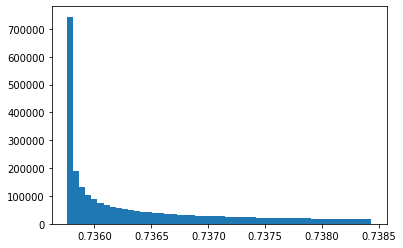

In [135]:
plt.hist(y_f, bins=50)
plt.show()

It does look like an exponential!

In [136]:
print("Fraction of retained numbers:", len(y_f)/len(y))

Fraction of retained numbers: 0.2615444


We could increase the fraction by increasing $M$.

In [22]:
# From Power, alpha = 1.5
r = np.random.rand(100000000) # 100M samples
xmin = min(r) * 0.1
y_pow = 1000 * (0.5/xmin) * (r/xmin)**(-1.5) # M = 10
y_exp = np.exp(-r)

# Compute f(r)/Mg(r)
y = y_exp/y_pow

# Reject samples
y_f = y[y < r]

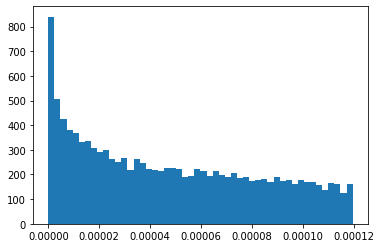

In [23]:
plt.hist(y_f, bins=50)
plt.show()

In [24]:
print("Fraction of retained numbers:", len(y_f)/len(y))

Fraction of retained numbers: 0.0001196


It looks like an exponential trend, however the fraction of retained numbers is very small. By increasing $r$ we could get a better exponential behavior, however it is too much work for my computer. Due to the huge number of numbers required, I will conclude that we cannot really get exponential sampling from the power distribution that we've used.

## Problem 3

In [33]:
# Generate (u,v)
N = int(1e5)
u = np.random.rand(N)
v = np.random.rand(N)

# Get upper bound on u
uv = np.sqrt(np.exp(-(v/u)))

# Get only u, v where 0 <= u <= uv
keep = u < uv

u = u[keep]
v = v[keep]

y = v/u

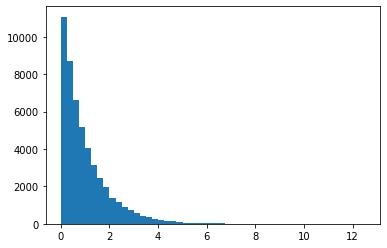

In [34]:
plt.hist(y, bins=50)
plt.show()

In [36]:
print("Fraction of retained numbers:", len(u)/len(uv))

Fraction of retained numbers: 0.49955


This is great! We need less random numbers, and the fraction of retained numbers is higher!